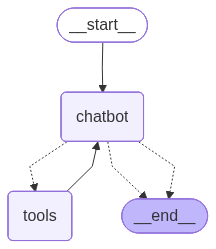

こんにちは！
こんにちは！何かお手伝いできることがありますか？
1足す2は？
1足す2は3です。何か他に計算したいことがありますか？
台湾観光について検索結果を教えて
台湾の観光地やアクティビティについていくつかの情報をお伝えします。

### 人気の観光地

1. **台北101**:
   - 台北のシンボルであり、高さ508メートルの超高層ビル。展望台からの景色は絶景です。

2. **故宮博物院**:
   - 中国の歴史的な美術品や文化財が展示されています。訪れる際には、特に「翠玉白菜」や「肉形石」が有名です。

3. **士林夜市**:
   - 台北で最も有名な夜市の一つ。地元の食べ物やお土産を楽しむことができます。

4. **九份**:
   - 美しい山間の町で、昔の金鉱町として知られています。風情ある街並みや茶屋、夜景が魅力的です。

5. **日月潭**:
   - 台湾最大の湖で、自然の美しさを楽しむことができます。サイクリングやボート遊びも人気です。

6. **阿里山**:
   - 美しい山岳風景が広がるエリアで、特に日の出や雲海が美しいと評判です。

### アクティビティ

- **夜市巡り**: 台湾各地にある夜市で、地元のストリートフードを楽しむことができます。
- **温泉**: 特に北投や礁溪での温泉体験は人気があります。
- **サイクリング**: 台湾の多くの地域ではサイクリング専用の道が整備されており、美しい風景を楽しみながらサイクリングできます。

### 交通手段

- **MRT（地下鉄）**: 台北市内の移動に便利で、主要な観光地へのアクセスが良いです。
- **バス**: 地元のバスも利用できますが、路線や時刻表を確認しておくと良いでしょう。
- **レンタルバイク**: 台北市内や観光地でのレンタルバイクも人気です。

これらの情報を参考にして、台湾の観光を楽しんでください！他に知りたいことがあれば教えてください。
ありがとうございました！


In [21]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ===== Stateクラスの定義 =====
class State(TypedDict):
    messages: Annotated[list, add_messages]

# ===== グラフの構築 =====
def build_graph(model_name):
    graph_builder = StateGraph(State)
    llm = ChatOpenAI(model_name=model_name)


    # チャットボットノードの作成
    def chatbot(state: State):
        return {"messages": [llm.invoke(state["messages"])]}

    # エントリーポイントの設定
    graph_builder.set_entry_point("chatbot")

    # チャットボットノードの追加
    graph_builder.add_node("chatbot", chatbot)

    # ツールノードの作成
    tool = TavilySearchResults(max_result=2)
    tools = [tool]
    llm_with_tools = llm.bind_tools(tools)
    tool_node = ToolNode(tools)
    graph_builder.add_node("tools", tool_node)

    # 条件付きノードの作成
    graph_builder.add_conditional_edges(
        "chatbot",
        tools_condition,
        {
            "tools": "tools",
            None: END,
            "__end__": END
        }

    )

    # ノードの接続
    graph_builder.add_edge("tools", "chatbot")

    memory = MemorySaver()
    return graph_builder.compile(checkpointer=memory)

# ===== グラフ実行関数 =====
def stream_graph_updates(graph: StateGraph, user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values"
    )
    for event in events:
        print(event["messages"][-1].content, flush=True)


# ===== メイン実行ロジック =====
# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini" 

# グラフの作成
# ソースコードを記述
graph = build_graph(model_name=MODEL_NAME)

# グラフの可視化
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

# メインループ
while True:
    user_input = input("質問:")
    if user_input.strip() == "":
        print("ありがとうございました！")
        break
    stream_graph_updates(graph, user_input)